<a href="https://colab.research.google.com/github/vincenthanna/maic/blob/main/MAIC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation, Add, Layer, GlobalAveragePooling1D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
from keras import optimizers
from keras.utils.vis_utils import plot_model

In [8]:
print(keras.__version__)

2.4.0


In [9]:
import os
import pandas as pd
import numpy as np

x_train = None
y_train = None
x_train_cases = None


BASE_DIR = "/content/drive/My Drive/data/maic"
FILE_TRAIN_CASES = "/content/drive/My Drive/data/maic/train_cases.csv"
df_tc = pd.read_csv(FILE_TRAIN_CASES)
df_tc.head(10)

if os.path.isfile(os.path.join(BASE_DIR, "x_train.npz")):
    print("loading train data...", flush=True, end="")
    x_train = np.load(os.path.join(BASE_DIR, "x_train.npz"))['arr_0']
    y_train = np.load(os.path.join(BASE_DIR, "y_train.npz"))['arr_0']
    x_train_cases = pd.read_csv(os.path.join(BASE_DIR, "x_train_cases.csv"))
    print("done")
    
PATH_XTEST_CSV = os.path.join(BASE_DIR, 'x_test_cases.csv')
X_TEST_NPZ = os.path.join(BASE_DIR, "x_test.npz")
if os.path.exists(X_TEST_NPZ) and os.path.exists(PATH_XTEST_CSV):
    print("loading test data..." , flush=True, end='')
    x_test = np.load(X_TEST_NPZ, allow_pickle=True)['arr_0']    
    x_test_cases = pd.read_csv(PATH_XTEST_CSV)
    print("done")
    
# cnn 입력으로 쓰기 위해 차원추가 (..., 1)
x_train = x_train[..., None]
x_test = x_test[..., None]

loading train data...done
loading test data...done


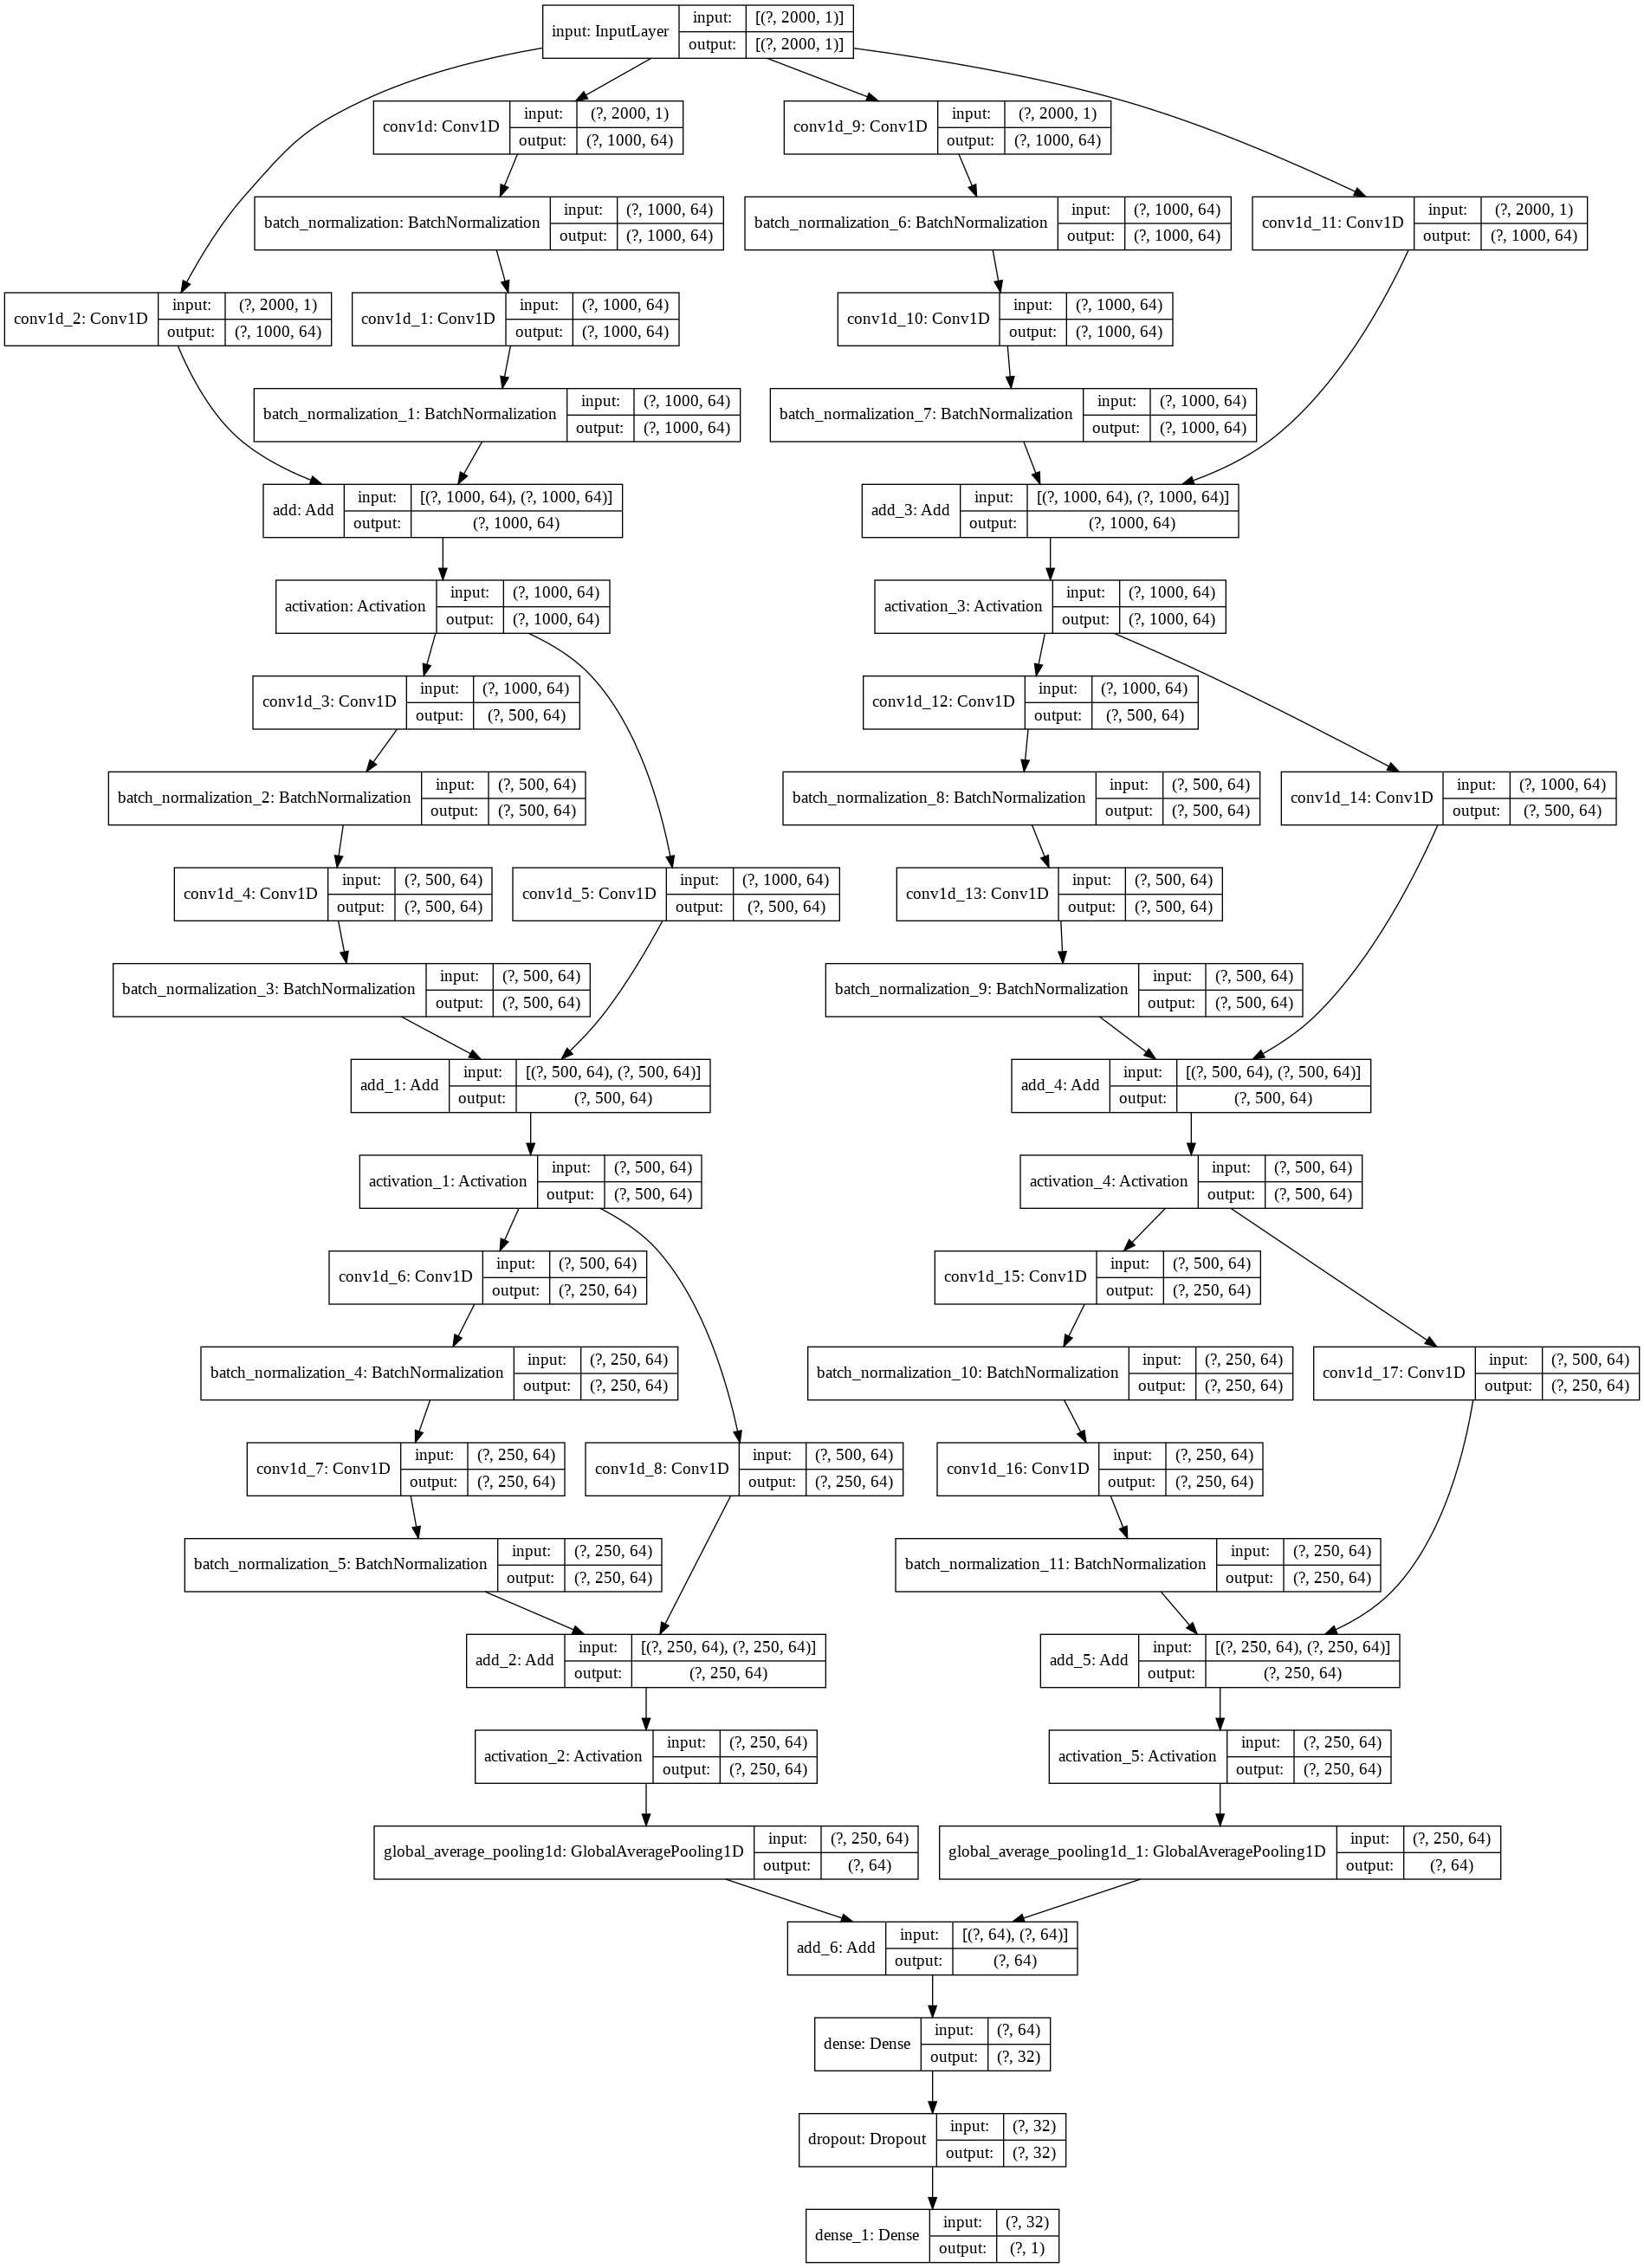

In [19]:
tf.keras.backend.clear_session()

input_tensor = Input(shape=(2000, 1), dtype='float32', name='input')

def resnet_basic_block(inputs, filters, kernel_size, strides):
    x = inputs
    shortcut = inputs
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)    
    
    x = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', activation=None)(x)
    x = keras.layers.BatchNormalization()(x)
    
    shortcut = keras.layers.Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(shortcut)    
    x = keras.layers.Add()([shortcut, x])
    x = keras.layers.Activation('relu')(x)
    return x


def resnet(inputs, kernel_size, filter_sizes):
    x = inputs
    for fsize in filter_sizes:
        x = resnet_basic_block(inputs=x, filters=fsize, kernel_size=kernel_size, strides=2)
    return x


def lowprenet(inputs, kernel_sizes, filter_sizes):
    sub_models = []
    for kernel_size in kernel_sizes:
        # sm = ResnetBase(kernel_size=kernel_size, filter_sizes=filter_sizes)
        sm = resnet(inputs, kernel_size=kernel_size, filter_sizes=filter_sizes)
        sm = keras.layers.GlobalAveragePooling1D()(sm)
        sub_models.append(sm)

    x = keras.layers.Add()(sub_models)
    x = keras.layers.Dense(units=32, activation='sigmoid')(x)
    x = keras.layers.Dropout(rate=0.2)(x)
    x = keras.layers.Dense(units=1, activation='sigmoid')(x)

    return keras.models.Model(inputs=[inputs], outputs=x)



kernel_sizes = [3, 5]
filter_sizes = [64, 64, 64]

opt = optimizers.Adam()

model = lowprenet(input_tensor, kernel_sizes=kernel_sizes, filter_sizes=filter_sizes)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.AUC()])
#model.summary()
# end = resnet_basic_block(input_tensor, filters=3, kernel_size=3, strides=2)
# model = keras.models.Model(inputs=[input_tensor], outputs=end)

plot_model(model, to_file='lowprenet.png', show_shapes=True, show_layer_names=True)

In [20]:
# 출력 폴더를 생성
outdir = "output"
if not os.path.exists(outdir):
    os.mkdir(outdir)
weight_path = os.path.join(outdir, "weights.hdf5")

try:
    os.remove(weight_path)
except:
    pass

BATCH_SIZE = 512
EPOCHS = 100

callbacks = []
callbacks.append(ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True))
callbacks.append(ReduceLROnPlateau(monitor = 'val_auc', factor = 0.5, patience=2, min_lr=0.00001, verbose=1, mode='max'))
callbacks.append(EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'))

# train model
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight={0:1, 1:10}, callbacks=callbacks)
#hist = model.fit(x_train, y_train, validation_split=0.1, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks)

print("Saving trained model...", end="")
open(os.path.join(outdir, "/model.json"), "wt").write(model.to_json())
print("done")


Epoch 1/100
1974/1974 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.9020 - auc: 0.8761
Epoch 00001: val_loss improved from inf to 0.26900, saving model to output/weights.hdf5
1974/1974 [==============================] - 232s 117ms/step - loss: 0.4980 - accuracy: 0.9020 - auc: 0.8761 - val_loss: 0.2690 - val_accuracy: 0.8814 - val_auc: 0.8933
Epoch 2/100
1973/1974 [============================>.] - ETA: 0s - loss: 0.4899 - accuracy: 0.9048 - auc: 0.8809
Epoch 00002: val_loss improved from 0.26900 to 0.23067, saving model to output/weights.hdf5
1974/1974 [==============================] - 231s 117ms/step - loss: 0.4899 - accuracy: 0.9048 - auc: 0.8809 - val_loss: 0.2307 - val_accuracy: 0.9154 - val_auc: 0.8924
Epoch 3/100
1973/1974 [============================>.] - ETA: 0s - loss: 0.4852 - accuracy: 0.9061 - auc: 0.8838
Epoch 00003: val_loss did not improve from 0.23067

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1974/1974 [

KeyboardInterrupt: ignored

In [12]:
model.load_weights(weight_path)

In [13]:
y_pred = model.predict(x_test).flatten()
np.savetxt("pred_y.txt", y_pred)